## Project 2

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

- [x] Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. 
- [x] Apply a distortion correction to raw images.
- [x] Use color transforms, gradients, etc., to create a thresholded binary image.
- [x] Apply a perspective transform to rectify binary image ("birds-eye view").
- [] Detect lane pixels and fit to find the lane boundary.
- [] Determine the curvature of the lane and vehicle position with respect to center.
- [] Warp the detected lane boundaries back onto the original image.
- [] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pdb
%matplotlib inline

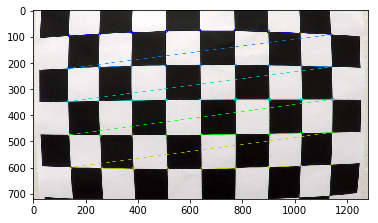

In [2]:
# Chessboard (9x5) camera_cal/calibration[1..20].jpg

nx = 9
ny = 5

ims = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D poiints in img-plane

objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates


for im in ims:
    
    # read in each image
    img = mpimg.imread(im)
    
    # convert to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

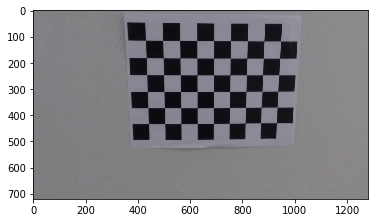

In [3]:
plt.imshow(dst)

In [4]:
# Define a function to apply the distortion correction

def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

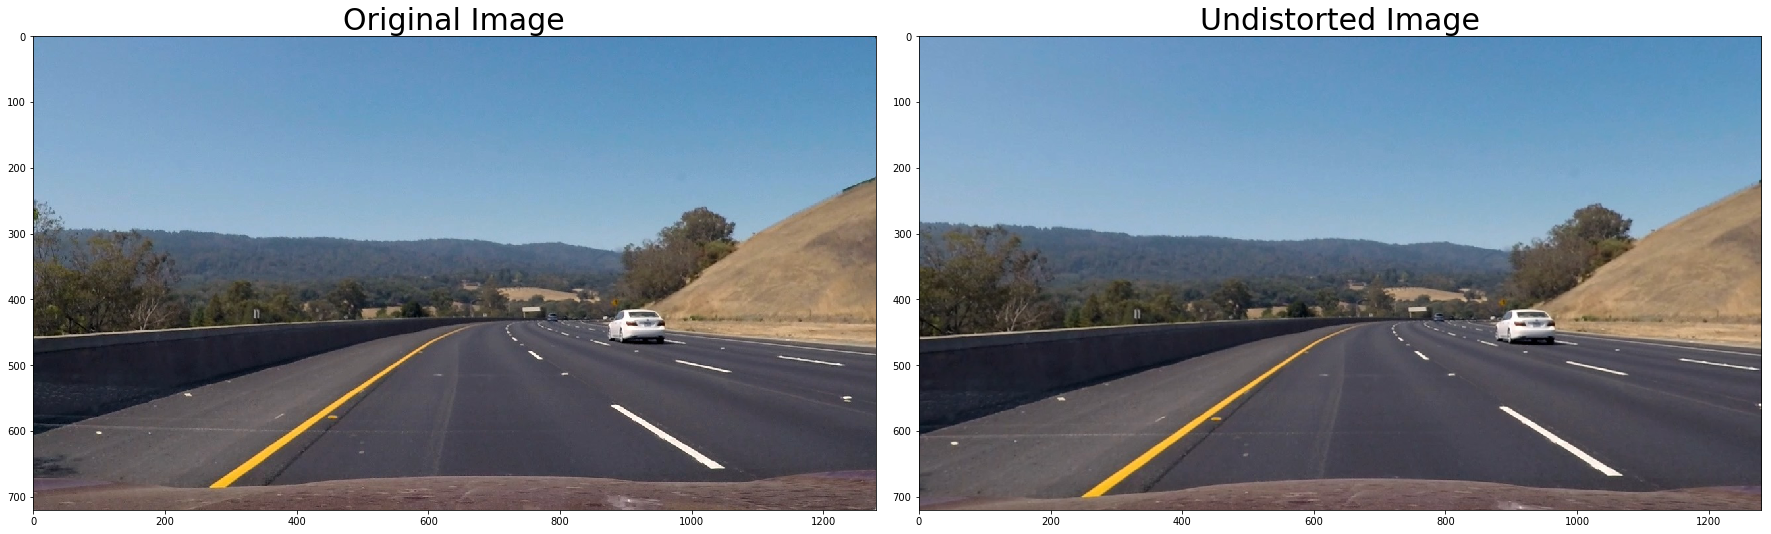

In [5]:
# Apply it to test-image
img = mpimg.imread('test_images/test3.jpg')
undist = cal_undistort(img,mtx,dist)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
# Create a threshold binary image - Color Transform

def create_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # convert to grayscale for Sobel-Operation
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combing the binary thresholds in one, according to lesson
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

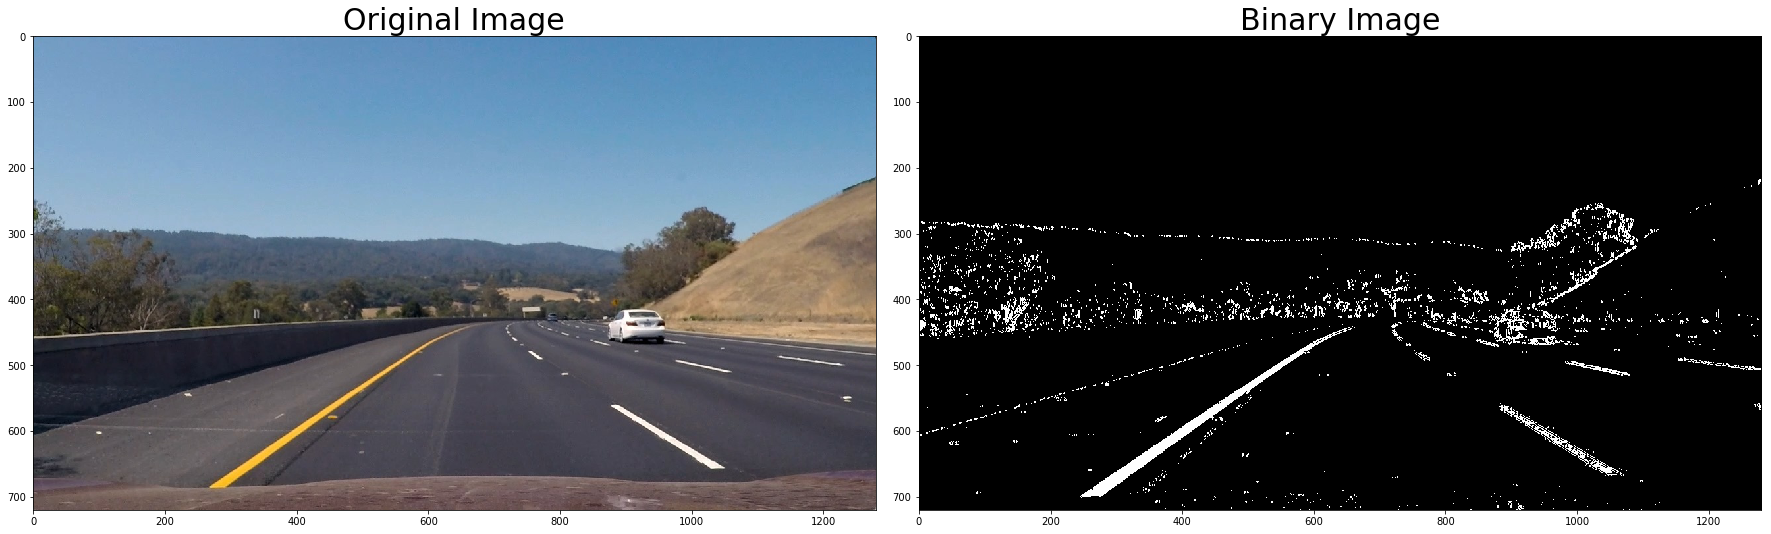

In [7]:
img = mpimg.imread('test_images/test3.jpg')
undist = cal_undistort(img,mtx,dist)
combined_binary = create_binary(undist, s_thresh=(170, 255), sx_thresh=(20,100))

#figsize in inch convert to cm by divide 2.54 (x,y)
f, (ax1,ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

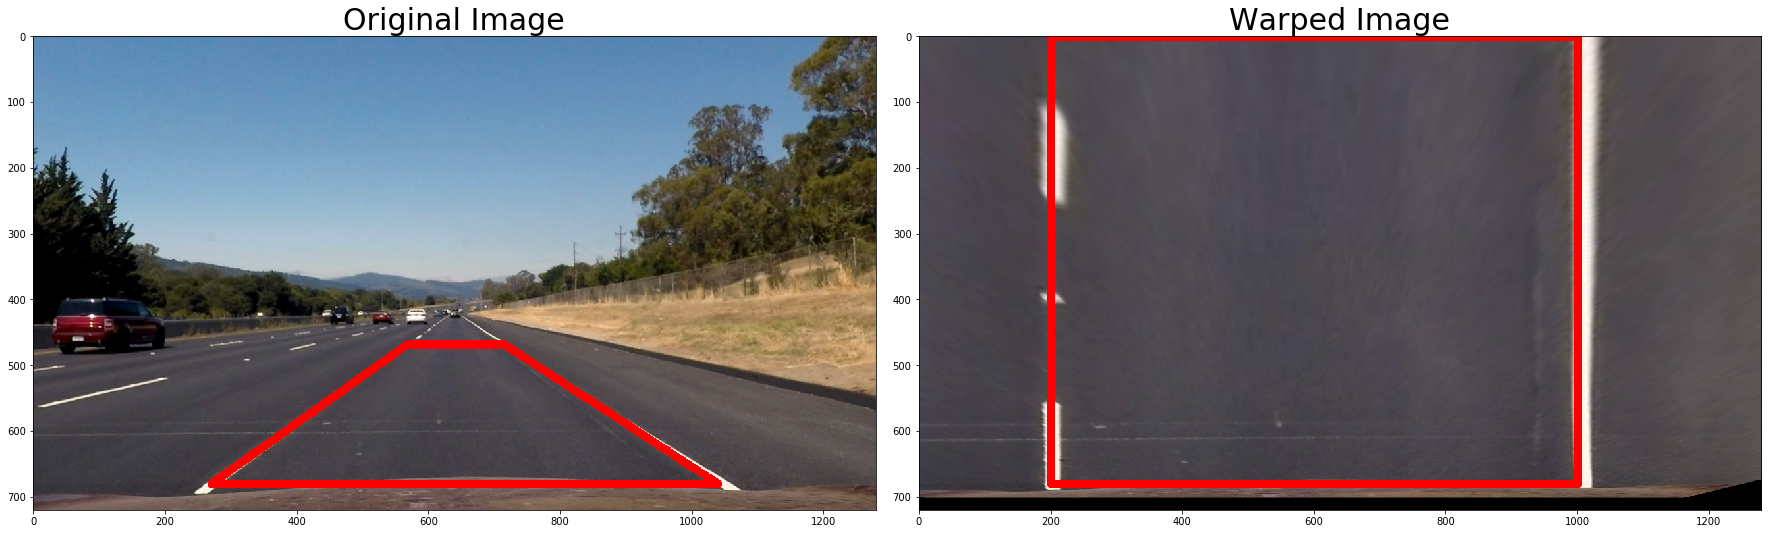

In [8]:
# Warp the image

# copy the first three lines to identify an appropriate test-image ...
img = mpimg.imread('test_images/straight_lines2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
undist = cal_undistort(img,mtx,dist)
combined_binary = create_binary(undist, s_thresh=(170, 255), sx_thresh=(20,100))

# Plan: Identify on a flat and parallel-line road the points and use this as warping-function ...

# the order of the points seems to have an influence on the result!
#top-right
#bottom-right
#bottom left
#top left

'''
src = np.float32(
    [[774,513],
     [1056,695],
     [251,695],
     [518,513]])

dst = np.float32(
     [[1056,150],
      [1056,695],
      [251,695],
      [251,150]])
'''

# Input help forum
src = np.float32(
    [[568,468],
     [715,468],
     [1040,680],
     [270,680]])

dst = np.float32(
     [[200,0],
      [1000,0],
      [1000,680],
      [200,680]])

# define 4 dst-points

def warp_the_image(img, src, dst):
    
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    
    # input, Transformation-Matrix, image.shape, How to interpolate
    warped_binary = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return M, M_inv, warped_binary

M, M_inv, out = warp_the_image(undist,src,dst)
#M, out = warp_the_image(combined_binary,src,dst)

f, (ax1,ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(undist)
ax1.imshow(cv2.line(undist,tuple(src[0]),tuple(src[1]),[255,0,0],12))
ax1.imshow(cv2.line(undist,tuple(src[1]),tuple(src[2]),[255,0,0],12))
ax1.imshow(cv2.line(undist,tuple(src[2]),tuple(src[3]),[255,0,0],12))
ax1.imshow(cv2.line(undist,tuple(src[3]),tuple(src[0]),[255,0,0],12))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(out, cmap='gray')
ax2.imshow(cv2.line(out,tuple(dst[0]),tuple(dst[1]),[255,0,0],12))
ax2.imshow(cv2.line(out,tuple(dst[1]),tuple(dst[2]),[255,0,0],12))
ax2.imshow(cv2.line(out,tuple(dst[2]),tuple(dst[3]),[255,0,0],12))
ax2.imshow(cv2.line(out,tuple(dst[3]),tuple(dst[0]),[255,0,0],12))
ax2.set_title('Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('output_images/warping.jpg')

In [9]:
# How does the transfomation matrix look?
print(M)

[[ -6.51305684e-01  -1.39400922e+00   9.98402458e+02]
 [ -2.66453526e-15  -2.01075269e+00   9.41032258e+02]
 [ -4.22838847e-18  -2.39247312e-03   1.00000000e+00]]


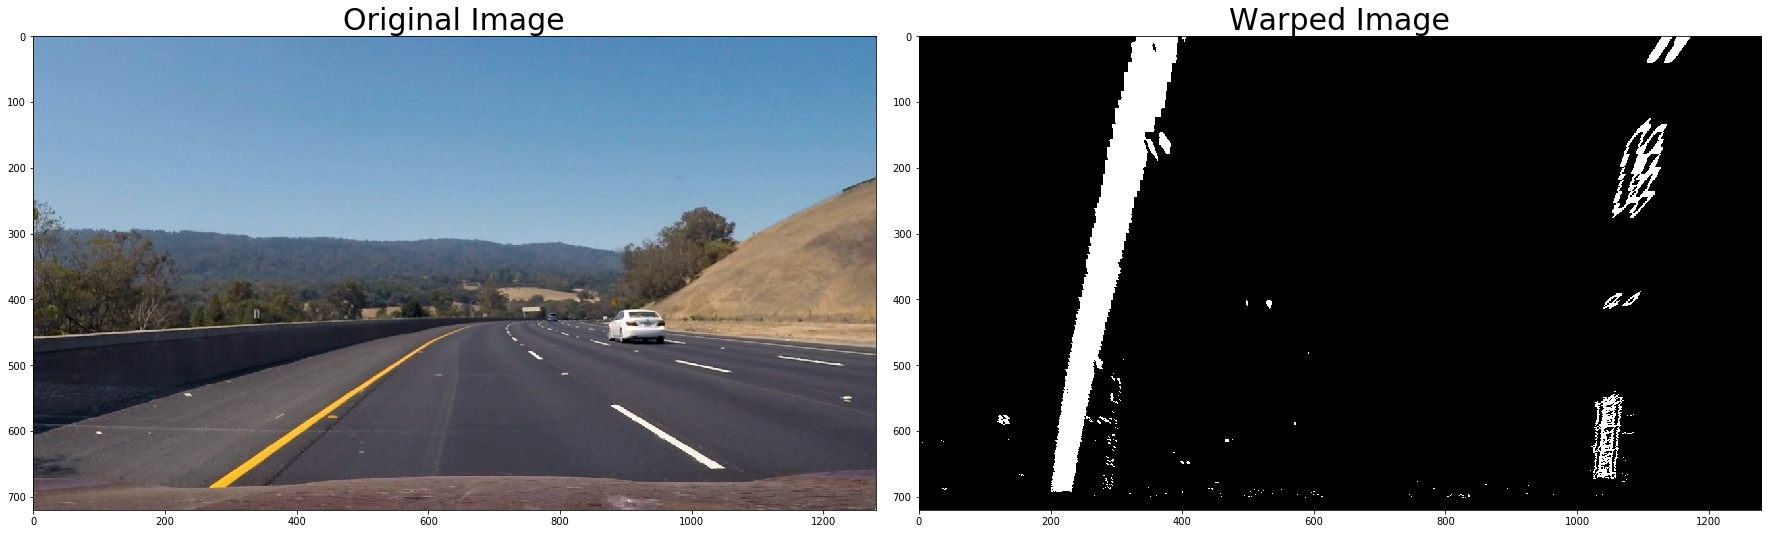

In [10]:
# Test - Write the binary image to a file
img = mpimg.imread('test_images/test3.jpg')
undist = cal_undistort(img,mtx,dist)
combined_binary = create_binary(undist, s_thresh=(170, 255), sx_thresh=(20,100))
warped_binary = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1],combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
f, (ax1,ax2) = plt.subplots(1,2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_binary,cmap='gray')
ax2.set_title('Warped Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#cv2.imwrite('output_images/my_warp.jpg',warped_binary*255)

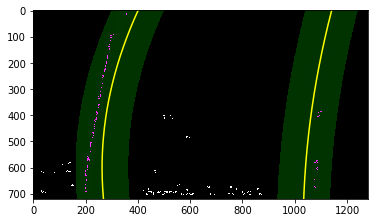

In [11]:
# Detect lane pixels and fit to find the lane boundary

# Own Code - Lesson 8, Chapter 4, ...

#warped_binary = warp_the_image(combined_binary, src, dst)
binary_warped = mpimg.imread('output_images/my_warp.jpg')/255

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    # start, stop, number of samples
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

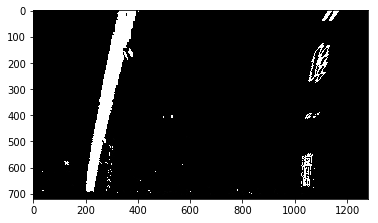

In [12]:
binary_warped = mpimg.imread('output_images/my_warp.jpg')/255
plt.imshow(binary_warped, cmap='gray')

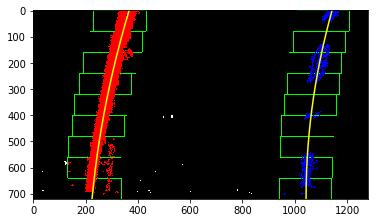

In [13]:
# Lesson 8, Chapter 4

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

binary_warped = mpimg.imread('output_images/my_warp.jpg')
out_img = fit_polynomial(binary_warped)
if(1):
    plt.imshow(out_img)

if(0):
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(24,9))
    f.tight_layout()
    ax1.imshow(binary_warped,cmap='gray')
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(out_img)
    ax2.set_title('Result', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

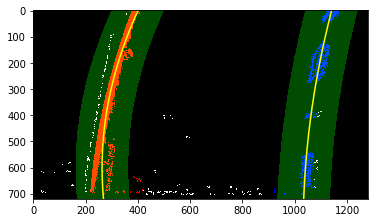

In [14]:
# Lesson 8, Chapter 5


# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('output_images/my_warp.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
# returns the continous values left_fitx, ploty (left-line), right_fitx, ploty (right-line)
result, left_fitx, right_fitx, ploty = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

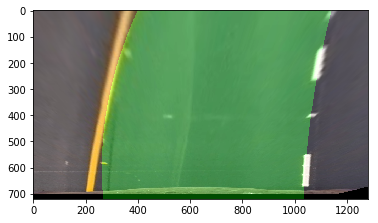

In [15]:
# Plot the result in the original image
img = mpimg.imread('test_images/test3.jpg')
undist = cal_undistort(img,mtx,dist)
warped_undist = cv2.warpPerspective(undist, M, (combined_binary.shape[1],combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
result2 = np.copy(warped_undist)
window_img = np.zeros_like(result2)
window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
road_surface = np.hstack((window1, window2))
cv2.fillPoly(window_img, np.int_([road_surface]), (0, 255, 0))
result = cv2.addWeighted(result2, 1, window_img, 0.3, 0)
plt.imshow(result)

In [31]:
print(road_surface.shape)
print(left_fitx.shape)
print(ploty.shape)
print(window1.shape)
print(window1[0,0:5,0:2])

(1, 1440, 2)
(720,)
(720,)
(1, 720, 2)
[[ 400.70299839    0.        ]
 [ 400.24603344    1.        ]
 [ 399.78982958    2.        ]
 [ 399.3343868     3.        ]
 [ 398.87970511    4.        ]]


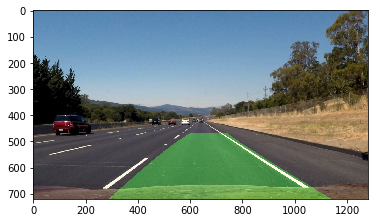

In [59]:
# Warp back to original image

unwarped_road_sf = cv2.warpPerspective(window_img, M_inv, (result.shape[1],result.shape[0]), flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(img, 1, unwarped_road_sf, 0.3, 0)
plt.imshow(result)

In [46]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
def measure_curvature_real(left_fitx, right_fitx, ploty, ym_per_pix, xm_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**(3/2))/(abs(2*left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**(3/2))/(abs(2*right_fit_cr[0]))  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx, ploty, ym_per_pix, xm_per_pix)

print(left_curverad, 'm', right_curverad, 'm')

431.643282685 m 1067.99739288 m


In [57]:
# Measure center position
camera_center = (left_fitx[-1] + right_fitx[-1])/2
center_diff = (camera_center - result.shape[1]/2)*xm_per_pix
side_pos = 'left'
if center_diff <= 0:
    side_pos = 'right'
    
print('Result.shape '+str(result.shape))
print('Camera center '+str(camera_center))
print('left_fitx(0:2)'+str(left_fitx[0:2]))
print('left_fitx(-3:-1)'+str(left_fitx[-3:-1]))
print(right_fitx[-1])
print(camera_center)
print(result.shape[1]/2)
print(center_diff)



Result.shape (720, 1280, 3)
Camera center 651.429767589
left_fitx(0:2)[ 400.70299839  400.24603344]
left_fitx(-3:-1)[ 268.41915611  268.50788956]
1034.26215109
651.429767589
640.0
0.0604144858279


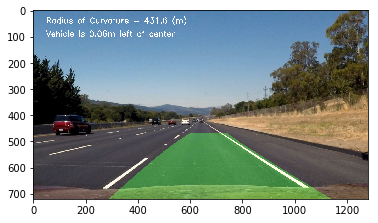

In [63]:
idx = 1
cv2.putText(result,'Radius of Curvature = '+str(round(left_curverad,1))+' (m)', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
plt.imshow(result)

out_path = './output_images/processed'+str(idx)+'.jpg'
cv2.imwrite(out_path,result)
idx = idx+1

## Repeat - Steps for the pipeline

- [x] Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. 
- [x] Apply a distortion correction to raw images.
- [x] Use color transforms, gradients, etc., to create a thresholded binary image.
- [x] Apply a perspective transform to rectify binary image ("birds-eye view").
- [x] Detect lane pixels and fit to find the lane boundary (left_fitx, ploty), (right_fitx, ploty)
- [] Determine the curvature of the lane and vehicle position with respect to center.
- [] Warp the detected lane boundaries back onto the original image.
- [] Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [18]:
# Prequisite
# 1. distortion correction - mtx, dist
# 2. calculate the transformation - M

def advanced_lane_finding_pipeline(raw_image,mtx,dist,M):
    image = np.copy(raw_image)
    # apply the distortion correction
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # create a binary image - color transform, gradients, ...
    combined_binary = create_binary(undist, s_thresh=(170, 255), sx_thresh=(20,100))
    # apply perspective transform ("birds-eye view")
    warped_binary = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1],combined_binary.shape[0]), flags=cv2.INTER_LINEAR)
    # detect lane pixels and fit to find the lane boundaray
    
    # determine the curvature
    # warp the boundarys back to the original image
    # output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position
    image_with_lines = warped_binary
    
    return image_with_lines

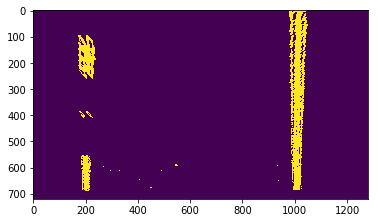

In [19]:
img = mpimg.imread('test_images/straight_lines2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
output = advanced_lane_finding_pipeline(img,mtx,dist,M)

plt.imshow(output)